In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [2]:
pd.set_option('display.max_columns', None)
path = 'G:/immigration/Article/Mortality-Rate/Mortality Municipality 2004-2020 new download.xlsx'
dfs = []
for year in range(2004, 2023):
    df_i = pd.read_excel(path, sheet_name=str(year))
    dfs.append(df_i)
    
df = pd.concat(dfs, axis=0)

df.columns = df.columns.str.strip()
df =df.loc[:, ~df.T.duplicated(keep = 'first')]

municipality = df.filter(regex=r'^Municipality \.\d+$').columns.tolist()
df = df.drop(municipality, axis=1)

year = df.filter(regex=r'^Year \.\d+$').columns.tolist()
df = df.drop(year, axis=1)

month = df.filter(regex=r'^Month \.\d+$').columns.tolist()
df = df.drop(month, axis=1)
df.columns.values[4] = 'Year.1'
df['Year'] = df['Year'].fillna(df['Year.1'])
df = df.drop(labels =['Unnamed: 2250', 'Year.1'], axis=1)

NAs = df.isnull().sum()
col = NAs[NAs <= 200].index
df = df[col]
df = df.drop('Municipality', axis=1)

In [3]:
df.head()

,Month of Death,Absecon City,Month,Atlantic City,Brigantine City,Buena Borough,Buena Vista Township,Corbin City,Egg Harbor City,Egg Harbor Township,Estell Manor City,Folsom Borough,Galloway Township,Hamilton Township (Atlantic),Hammonton Town,Linwood City,Longport Borough,Margate City,Mullica Township,Northfield City,Pleasantville City,Port Republic City,Somers Point City,Ventnor City,Weymouth Township,"Bergen County, municipality unknown",Allendale Borough,Alpine Borough,Bergenfield Borough,Bogota Borough,Carlstadt Borough,Cliffside Park Borough,Closter Borough,Cresskill Borough,Demarest Borough,Dumont Borough,Elmwood Park Borough,East Rutherford Borough,Edgewater Borough,Emerson Borough,Englewood City,Englewood Cliffs Borough,Fair Lawn Borough,Fairview Borough,Fort Lee Borough,Franklin Lakes Borough,Garfield City,Glen Rock Borough,Hackensack City,Harrington Park Borough,Hasbrouck Heights Borough,Haworth Borough,Hillsdale Borough,Ho-Ho-Kus Borough,Leonia Borough,Little Ferry Borough,Lodi Borough,Lyndhurst Borough,Mahwah Township,Maywood Borough,Midland Park Borough,Montvale Borough,Moonachie Borough,New Milford Borough,North Arlington Borough,Northvale Borough,Norwood Borough,Oakland Borough,Old Tappan Borough,Oradell Borough,Palisades Park Borough,Paramus Borough,Park Ridge Borough,Ramsey Borough,Ridgefield Borough,Ridgefield Park Village,Ridgewood Village,River Edge Borough,River Vale Township,Rochelle Park Township,Rockleigh Borough,Rutherford Borough,Saddle River Borough,Saddle Brook Township,South Hackensack Township,Teaneck Township,Tenafly Borough,Upper Saddle River Borough,Waldwick Borough,Wallington Borough,Washington Township (Bergen),Westwood Borough,Woodcliff Lake Borough,Wood-Ridge Borough,Wyckoff Township,Bass River Township,Beverly City,Bordentown City,Bordentown Township,Burlington City,Burlington Township,Chesterfield Township,Cinnaminson Township,Delanco Township,Delran Township,Eastampton Township,Edgewater Park Township,Evesham Township,Fieldsboro Borough,Florence Township,Hainesport Township,Lumberton Township,Mansfield Township (Burlington),Maple Shade Township,Medford Township,Medford Lakes Borough,Moorestown Township,Mount Holly Township,Mount Laurel Township,New Hanover Township,North Hanover Township,Palmyra Borough,Pemberton Borough,Pemberton Township,Riverside Township,Riverton Borough,Shamong Township,Southampton Township,Springfield Township (Burlington),Tabernacle Township,Washington Township (Burlington),Westampton Township,Willingboro Township,Woodland Township,Wrightstown Borough,Audubon Borough,Audubon Park Borough,Barrington Borough,Bellmawr Borough,Berlin Borough,Berlin Township,Brooklawn Borough,Camden City,Chesilhurst Borough,Clementon Borough,Collingswood Borough,Cherry Hill Township,Gibbsboro Borough,Gloucester City,Gloucester Township,Haddonfield Borough,Haddon Heights Borough,Haddon Township,Hi-Nella Borough,Laurel Springs Borough,Lawnside Borough,Lindenwold Borough,Magnolia Borough,Merchantville Borough,Mount Ephraim Borough,Oaklyn Borough,Pennsauken Township,Pine Hill Borough,Runnemede Borough,Somerdale Borough,Stratford Borough,Voorhees Township,Waterford Township,Winslow Township,Woodlynne Borough,Avalon Borough,Cape May City,Cape May Point Borough,Dennis Township,Lower Township,Middle Township,North Wildwood City,Ocean City,Sea Isle City,Stone Harbor Borough,Upper Township,West Cape May Borough,West Wildwood Borough,Wildwood City,Wildwood Crest Borough,Woodbine Borough,Bridgeton City,Commercial Township,Deerfield Township,Downe Township,Fairfield Township (Cumberland),Greenwich Township (Cumberland),Hopewell Township (Cumberland),Lawrence Township (Cumberland),Maurice River Township,Millville City,Shiloh Borough,Stow Creek Township,Upper Deerfield Township,Vineland City,"Essex County, municipality unknown",Belleville Township,Bloomfield Township,Caldwell Boro Township,Fairfield Township (Essex),Cedar Grove Township,East Orange City,Essex Fells Township,Glen Ridge Boro Township,I

In [4]:
features = ['Month of Death', 'Month', 'Year']
Municipalities = list(set(df.columns) - set(features))
df = pd.melt(df, id_vars = features, value_vars= Municipalities, var_name= 'Municipalities', value_name= 'Mortality_Count')
df['Municipalities'] = df['Municipalities'].str.strip()
df['Municipalities'].replace({'Glen Ridge Boro': 'Glen Ridge Borough', 'Caldwell Boro': 'Caldwell Borough', 'North Caldwell ugh':'North Caldwell'},regex= True, inplace=True)
df = df[~df['Municipalities'].str.contains('municipality unknown')]
df['Mortality_Count'] = df['Mortality_Count'].fillna(0).replace({'**': 0})

In [5]:
df.tail()

,Month of Death,Month,Year,Municipalities,Mortality_Count
143502,May,5.0,2022.0,Stafford Township,25.0
143503,June,6.0,2022.0,Stafford Township,25.0
143504,July,7.0,2022.0,Stafford Township,24.0
143505,August,8.0,2022.0,Stafford Township,34.0
143506,September,9.0,2022.0,Stafford Township,23.0


In [6]:
path = 'G:/immigration/Article/Mortality-Rate/jersey_monthly_dataset.xlsx'
df_t = pd.read_excel(path)
df_t = df_t.dropna()
df_t.head()

,MUN,COUNTY,Municipalities,GNIS,MUN_CODE,lat,lon,Year,Month,m_mean_temp,m_tmin,m_tmax,m_min_prcp,m_max_prcp,m_sum_prcp,mean_prcp,mean_Rhum,m_min_Rhum,m_max_Rhum
0,CAPE MAY POINT BORO,CAPE MAY,Cape May Point Borough,885179,503,38.937335,-74.965198,2000.0,1.0,1.024355,-13.26,19.58,0.0,18.29,79.30,2.558065,69.501560,47.086363,84.808964
1,CAPE MAY POINT BORO,CAPE MAY,Cape May Point Borough,885179,503,38.937335,-74.965198,2000.0,2.0,4.218621,-8.92,22.93,0.0,19.10,42.04,1.449655,67.060847,50.591712,83.992564
2,CAPE MAY POINT BORO,CAPE MAY,Cape May Point Borough,885179,503,38.937335,-74.965198,2000.0,3.0,8.954032,-3.48,25.39,0.0,57.43,174.10,5.616129,67.007058,51.080758,95.535715
3,CAPE MAY POINT BORO,CAPE MAY,Cape May Point Borough,885179,503,38.937335,-74.965198,2000.0,4.0,11.195167,0.55,24.78,0.0,20.76,73.40,2.446667,71.483713,49.085988,93.198143
4,CAPE MAY POINT BORO,CAPE MAY,Cape May Point Borough,885179,503,38.937335,-74.965198,2000.0,5.0,17.880323,1.81,33.25,0.0,39.59,102.56,3.308387,71.143740,54.963529,90.960663


In [7]:
df_merge = pd.merge(df, df_t,
                    on = ['Year', 'Month', 'Municipalities'], how = 'left')
df_merge.head()

,Month of Death,Month,Year,Municipalities,Mortality_Count,MUN,COUNTY,GNIS,MUN_CODE,lat,lon,m_mean_temp,m_tmin,m_tmax,m_min_prcp,m_max_prcp,m_sum_prcp,mean_prcp,mean_Rhum,m_min_Rhum,m_max_Rhum
0,Total,NaN,2004.0,Eastampton Township,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,January,1.0,2004.0,Eastampton Township,2.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,-3.718548,-16.24,13.62,0.0,13.20,63.06,2.034194,73.792126,52.740248,89.246152
2,October,10.0,2004.0,Eastampton Township,4.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,12.392097,1.76,24.68,0.0,17.66,66.55,2.146774,70.378457,53.306389,92.575691
3,November,11.0,2004.0,Eastampton Township,5.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,8.112167,-5.03,20.22,0.0,35.17,129.16,4.305333,68.355432,53.298979,84.036246
4,December,12.0,2004.0,Eastampton Township,5.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,2.391833,-12.37,15.30,0.0,15.94,83.16,2.772000,68.996343,47.263244,86.741266


In [8]:
path = 'G:/immigration/Article/Mortality-Rate/Municipality/Population.xlsx'
df_pop = pd.read_excel(path, sheet_name= 'Sheet5')
features = ['Name']
Years = list(set(df_pop.columns) - set(features))
df_pop = pd.melt(df_pop, id_vars = features, value_vars= Years, var_name= 'Year', value_name= 'Population')
df_pop.rename(columns = {'Name': 'Municipalities'}, inplace=True)
df_pop['Municipalities'] = df_pop['Municipalities'].str.strip()
df_pop.head()

,Municipalities,Year,Population
0,Aberdeen Township,2004,11125.0
1,Absecon City,2004,4055.0
2,Alexandria Township,2004,5712.0
3,Allamuchy Township,2004,-1749.0
4,Allendale Borough,2004,4447.0


In [9]:
df_yearly = pd.merge(df_merge, df_pop,
                    on = ['Year', 'Municipalities'], how = 'left')
df_yearly['Population'] = df_yearly['Population'].abs()
df_yearly = df_yearly[df_yearly['Month of Death'] != 'Total']
df_yearly = df_yearly.dropna()
df_yearly['Mortality_Rate'] = (df_yearly['Mortality_Count'] / df_yearly['Population'])*100
df_yearly['Year'] = df_yearly['Year'].astype(int).astype(str)
df_yearly['Month'] = df_yearly['Month'].astype(int).astype(str).str.zfill(2)
df_yearly['Date'] = pd.to_datetime(df_yearly['Year'] + df_yearly['Month'], format='%Y%m')
df_yearly.head()

,Month of Death,Month,Year,Municipalities,Mortality_Count,MUN,COUNTY,GNIS,MUN_CODE,lat,lon,m_mean_temp,m_tmin,m_tmax,m_min_prcp,m_max_prcp,m_sum_prcp,mean_prcp,mean_Rhum,m_min_Rhum,m_max_Rhum,Population,Mortality_Rate,Date
1,January,01,2004,Eastampton Township,2.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,-3.718548,-16.24,13.62,0.0,13.20,63.06,2.034194,73.792126,52.740248,89.246152,5337.0,0.037474,2004-01-01
2,October,10,2004,Eastampton Township,4.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,12.392097,1.76,24.68,0.0,17.66,66.55,2.146774,70.378457,53.306389,92.575691,5337.0,0.074948,2004-10-01
3,November,11,2004,Eastampton Township,5.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,8.112167,-5.03,20.22,0.0,35.17,129.16,4.305333,68.355432,53.298979,84.036246,5337.0,0.093686,2004-11-01
4,December,12,2004,Eastampton Township,5.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,2.391833,-12.37,15.30,0.0,15.94,83.16,2.772000,68.996343,47.263244,86.741266,5337.0,0.093686,2004-12-01
5,February,02,2004,Eastampton Township,4.0,EASTAMPTON TWP,BURLINGTON,882105.0,311.0,40.000981,-74.755335,1.255345,-11.84,18.14,0.0,40.71,79.06,2.726207,66.153207,47.535000,80.264450,5337.0,0.074948,2004-02-01


In [ ]:
df_yearly.to_excel('Downloads/df_yearly.xlsx')

In [10]:
df_yearly['MUN_CODE'].nunique()

559

In [11]:
df_yearly['Municipalities'].nunique()

559

In [12]:
df_yearly.shape

(127452, 24)

# Data Understanding

## Municipalities Information

In [151]:
Mortality_MEAN = df_yearly.groupby('Municipalities').agg({'Mortality_Count': 'mean',
                                                         'Mortality_Rate': 'mean',
                                                         'lat': 'first',
                                                         'lon':'first',
                                                         'MUN_CODE': 'first'}).reset_index()

In [152]:
Mortality_MEAN.to_excel('Downloads/Municipality_Info.xlsx')

C:\Users\BARTAR\AppData\Local\Temp\ipykernel_11652\2571348131.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Mortality_MEAN['Municipalities'][:60], rotation='vertical')


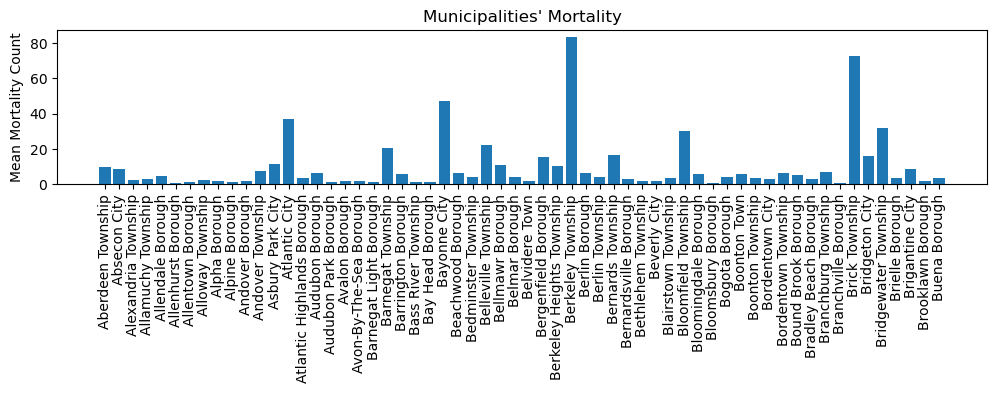

In [224]:
fig, ax = plt.subplots(figsize=(12,2))
ax.bar(Mortality_MEAN['Municipalities'][:60], Mortality_MEAN['Mortality_Count'][:60], align='center')
ax.set_xticklabels(Mortality_MEAN['Municipalities'][:60], rotation='vertical')
ax.set_ylabel('Mean Mortality Count')
ax.set_title("Municipalities' Mortality")
plt.show()

## Mortality By Year

In [153]:
Year_Info = df_yearly.groupby('Year').agg({'Mortality_Count': 'sum'}).reset_index()

In [154]:
Year_Info.to_excel('Downloads/Year_Info.xlsx')

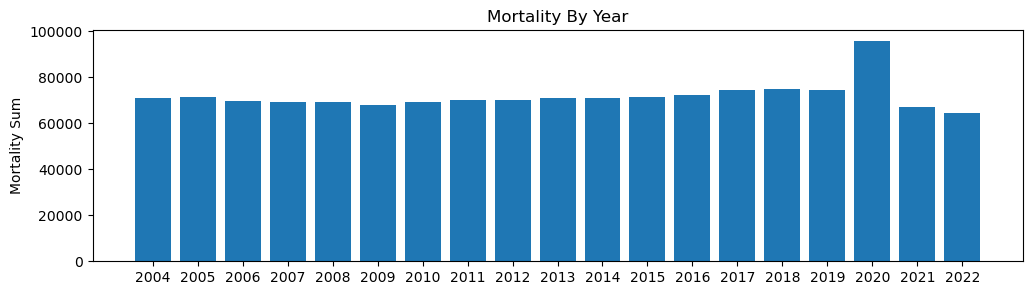

In [225]:
fig, ax = plt.subplots(figsize=(12,3))
ax.bar(Year_Info['Year'], Year_Info['Mortality_Count'], align='center')
ax.set_ylabel('Mortality Sum')
ax.set_title('Mortality By Year')
plt.show()

## Mortality By Month

In [226]:
Month_Info = df_yearly.groupby('Month of Death').agg({'Mortality_Count': 'sum'}).reset_index()

In [156]:
Month_Info.to_excel('Downloads/Month_Info.xlsx')

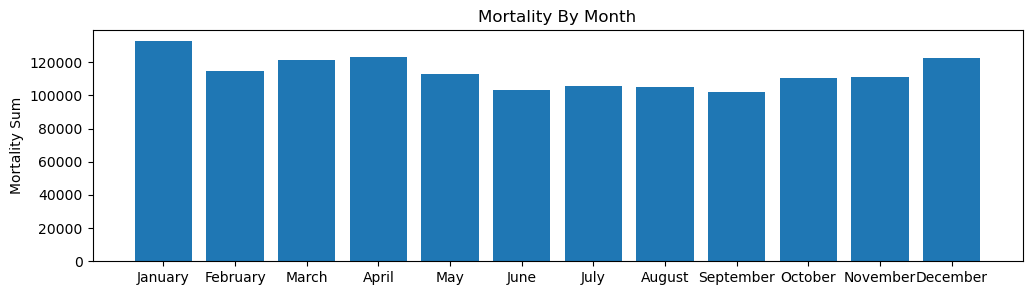

In [227]:
fig, ax = plt.subplots(figsize=(12,3))
months_order = list(calendar.month_name)[1:]
Month_Info['Month of Death'] = pd.Categorical(Month_Info['Month of Death'], categories=months_order, ordered=True)
ax.bar(Month_Info['Month of Death'], Month_Info['Mortality_Count'], align='center')
ax.set_ylabel('Mortality Sum')
ax.set_title('Mortality By Month')
plt.show()

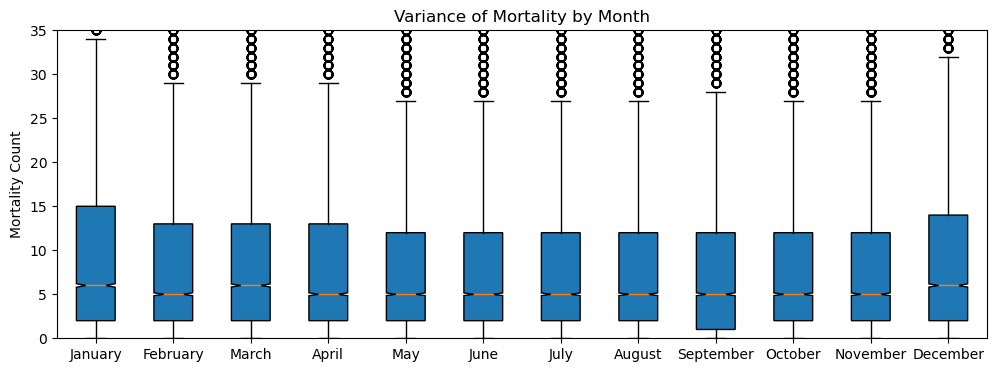

In [228]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.boxplot(df_yearly.groupby('Month of Death')['Mortality_Count'].apply(list), patch_artist=True, notch=True)

months=df_yearly['Month of Death'].unique()
ax.set_xticklabels(months)
ax.set_ylabel('Mortality Count')
ax.set_title('Variance of Mortality by Month')
ax.set_ylim(0, 35)

plt.show()

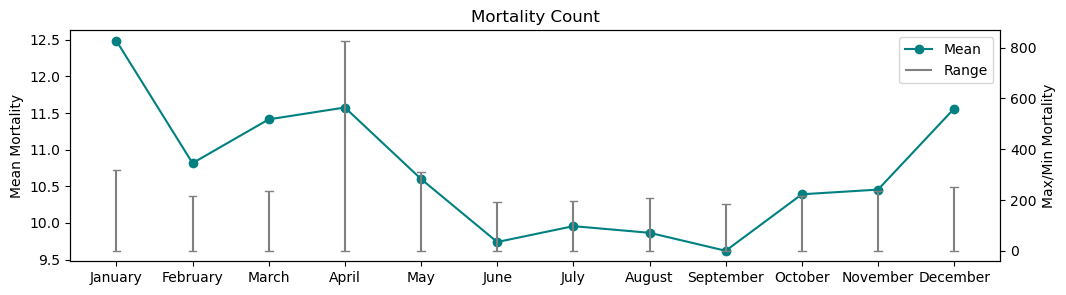

In [233]:
Month_Info_mean = df_yearly.groupby('Month of Death').agg({'Mortality_Count': ['mean', 'min', 'max']}).reset_index()

months_order = list(calendar.month_name)[1:]
Month_Info_mean['Month of Death'] = pd.Categorical(Month_Info_mean['Month of Death'], categories=months_order, ordered=True)

Month_Info_mean = Month_Info_mean.sort_values('Month of Death')

fig, ax1 = plt.subplots(figsize=(12, 3))
ax2 = ax1.twinx()

months = Month_Info_mean['Month of Death']
mortality_mean = Month_Info_mean['Mortality_Count', 'mean']
mortality_min = Month_Info_mean['Mortality_Count', 'min']
mortality_max = Month_Info_mean['Mortality_Count', 'max']

ax1.plot(months, mortality_mean, marker='o', color='teal', label='Mean')
ax1.set_ylabel('Mean Mortality')

ax2.vlines(months.index, mortality_min, mortality_max, color='gray', label='Range')
ax2.set_ylabel('Max/Min Mortality')

line_length = 0.05
for i in range(len(months)):
    x = months.index[i]
    y_min = mortality_min.iloc[i]
    y_max = mortality_max.iloc[i]
    ax2.plot([x - line_length, x + line_length], [y_min, y_min], color='gray', linewidth=1)
    ax2.plot([x - line_length, x + line_length], [y_max, y_max], color='gray', linewidth=1)

ax1.set_title('Mortality Count')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.xticks(rotation=45)  

plt.show()

## Mortality By Year-Month

In [157]:
Year_month_info = df_yearly.groupby(['Year', 'Month', 'Month of Death', 'Date']).agg({'Mortality_Count': 'sum'}).reset_index()

In [158]:
Year_month_info.to_excel('Downloads/Year_month_info.xlsx')

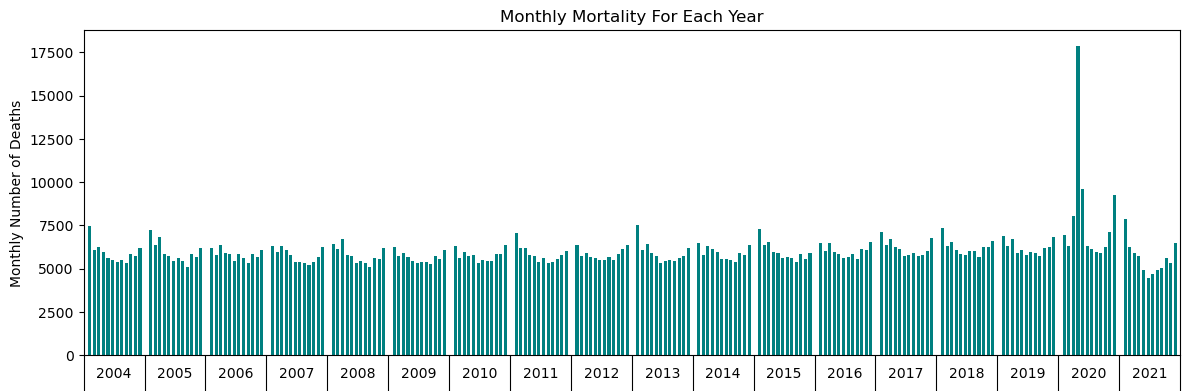

In [150]:
years = Year_month_info['Year'].unique()
x_ticks = range(len(years))
x_ticks_shifted = [tick + 0.35 for tick in x_ticks]
x_tick_labels = [str(year) for year in years]

bar_positions = [x + (0.9 / 12) * (month - 1) for x in x_ticks for month in range(1, 13)]

bar_heights = []
for year in years:
    bar_heights.extend(Year_month_info[Year_month_info['Year'] == year]['Mortality_Count'])

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(bar_positions, bar_heights, width=0.6/12, color = 'teal')

ax.set_xticks([])

pos = np.array(x_ticks_shifted) - 0.45

ax.vlines(pos, 0, -0.12, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())

for year, pos0, pos1 in zip(years, pos[:-1], pos[1:]):
    ax.text((pos0 + pos1) / 2, -0.07, year, ha='center', clip_on=False, transform=ax.get_xaxis_transform())

ax.set_xlim(pos[0], pos[-1])
ax.set_ylim(ymin=0)
ax.set_ylabel('Monthly Number of Deaths')
ax.set_title('Monthly Mortality For Each Year')
ax.xaxis.set_label_coords(0.5, 0.15)

plt.tight_layout()
plt.show()

# Modeling

In [10]:
path = 'G:/immigration/Article/Mortality-Rate/NM3.xlsx'
df_NM = pd.read_excel(path)
#df_NM = df_NM[df_NM['src_MUN_CODE'].isin(existing_MUN)]

In [11]:
src_FID = df_NM["src_FID"]
nbr_FID = df_NM["nbr_FID"]
src_MUN_CODE = df_NM["src_MUN_CODE"]
M0 = pd.DataFrame({"src_FID": src_FID, "nbr_FID": nbr_FID, "src_MUN_CODE": src_MUN_CODE})
NM = np.zeros((559, 559))

In [12]:
M0.head()

,src_FID,nbr_FID,src_MUN_CODE
0,0,6,503
1,1,2,512
2,1,6,512
3,2,1,502
4,2,6,502


In [13]:
M0.shape

(2918, 3)

In [14]:
namev = np.empty(559, dtype=object)

In [15]:
for i in range(1,560):
    temp = np.where(M0["src_FID"] == i - 1)[0]
    namev[i-1] = M0.loc[temp[0], 'src_MUN_CODE']
    NM[i-1, M0.loc[temp, 'nbr_FID']] = 1

In [16]:
namev_NM2 = np.array(namev)[np.where(NM[1, :] == 1)]
sum_NM = np.sum(NM)
sum_NM                            

2918.0

In [17]:
NM_df = pd.DataFrame(NM)
NM_df.index = namev
NM_df.columns = namev
NM1 = NM_df.sort_index(axis=0, ascending=True).sort_index(axis=1, ascending=True)
NM1

,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,263,264,265,266,267,268,269,270,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,430,431,432,434,435,436,437,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,601,602,603,604,605,606,607,608,609,610,611,612,613,614,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,901,902,903,904,905,906,907,908,909,910,911,912,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1101,1102,1103,1104,1105,1106,1107,1108,1111,1112,1113,1114,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1501,1502,1503,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1515,1516,1517,1519,1520,1521,1522,1523,1524,1525,1526,1527,1528,1529,1530,1531,1532,1533,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1924,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114,2115,2116,2117,2119,2120,2121,2122,2123
101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [19]:
NM1.to_excel('Downloads/NM1.xlsx')

In [53]:
Date = df_yearly['Date']
municipalities = df_yearly['Municipalities']
mean_hum = df_yearly['mean_Rhum']
mean_hum_Data = pd.DataFrame({'Municipalitie': municipalities, 'Date': Date, 'mean_humidity': mean_hum})

In [20]:
import pymc3 as pm

# Define your formula and data
formula = "Mortality_Count ~ offset(Population) + m_mean_temp + m_tmin + m_tmax + m_min_prcp + m_max_prcp + m_sum_prcp + mean_prcp + mean_Rhum + m_min_Rhum + m_max_Rhum + Population"
data = pd.DataFrame({'Mortality_Count': Y, 'Population': X, 'm_mean_temp': X, 'm_tmin': X, 'm_tmax': X, 'm_min_prcp': X, 'm_max_prcp': X, 'm_sum_prcp': X, 'mean_prcp': X, 'mean_Rhum': X, 'm_min_Rhum': X, 'm_max_Rhum': X})

with pm.Model() as model:
    # Priors
    tau2 = pm.HalfCauchy('tau2', beta=1, shape=len(data))
    rho_S = pm.Uniform('rho_S', lower=0, upper=1)
    rho_T = pm.Uniform('rho_T', lower=0, upper=1)

    # Linear predictor
    mu = pm.Deterministic('mu', pm.math.exp(pm.math.dot(data, pm.math.stack([pm.math.log(pm.math.abs(tau2)), rho_S, rho_T], axis=0))))

    # Likelihood
    obs = pm.Poisson('obs', mu=mu, observed=data['Mortality_Count'])

    # Run the model
    trace = pm.sample(1000, tune=1000)

# Print the summary
pm.summary(trace)

ModuleNotFoundError: No module named 'pymc3'

In [95]:
formula = "Mortality_Count ~ offset(Population) + m_mean_temp + m_tmin + m_tmax + m_min_prcp + m_max_prcp+ m_sum_prcp + mean_prcp + mean_Rhum + m_min_Rhum + m_max_Rhum + Population"
model = sm.GLM(Y, sm.add_constant(X), family=sm.families.Poisson(), spatial_weight= NM1, formula= formula)
results = model.fit()
print(results.summary())

C:\Users\BARTAR\anaconda3\envs\mlenv\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['spatial_weight']
  warnings.warn(msg, ValueWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:        Mortality_Count   No. Observations:               127452
Model:                            GLM   Df Residuals:                   127441
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.4254e+05
Date:                Thu, 24 Aug 2023   Deviance:                   1.4701e+06
Time:                        21:01:03   Pearson chi2:                 1.84e+06
No. Iterations:                     9   Pseudo R-squ. (CS):             0.9886
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6071      0.029     55.618      

In [90]:
summary_results = results.summary()
coef_summary  = summary_results.tables[1]
coef_summary = pd.DataFrame(coef_summary.data[1:], columns=coef_summary.data[0])
print(coef_summary)

                       coef    std err          z   P>|z|     [0.025  \
0         const      1.6071      0.029     55.618   0.000      1.550   
1   m_mean_temp     -0.0221      0.001    -33.728   0.000     -0.023   
2        m_tmin      0.0137      0.000     28.111   0.000      0.013   
3        m_tmax      0.0025      0.000      6.099   0.000      0.002   
4    m_min_prcp   4.131e-14   7.45e-16     55.480   0.000   3.99e-14   
5    m_max_prcp      0.0001   6.28e-05      2.077   0.038   7.36e-06   
6    m_sum_prcp      0.0031      0.000     10.656   0.000      0.003   
7     mean_prcp     -0.1061      0.009    -11.959   0.000     -0.123   
8     mean_Rhum      0.0203      0.000     45.744   0.000      0.019   
9    m_min_Rhum     -0.0046      0.000    -18.250   0.000     -0.005   
10   m_max_Rhum     -0.0045      0.000    -16.064   0.000     -0.005   
11   Population   7.841e-06   7.06e-09   1111.203   0.000   7.83e-06   

       0.975]  
0       1.664  
1      -0.021  
2       0.015  

In [91]:
modelfit = results.deviance
print(modelfit)

1470056.4299967866


In [92]:
print(formula)

Mortality_Count ~ offset(Population) + m_mean_temp
